In [35]:
import torch
import math
import cvxpy as cp
import numpy as np
from constraints import *
from helper import *
import copy
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

In [62]:
def dA_2(i,j,k,l,n):
    if i==k and j==l:
        return 1
    elif i==k and j==n+l:
        return -1
    return 0

def dz_tilde(A,b,c):
    m, n = A.shape[0], A.shape[1]
    A2 = np.hstack([A,-A,np.eye(m)])
    c2 = np.vstack([c,-c,np.zeros((m,1))])

    dz_dA2, dz_db = dz_2(A2,b,c2)
    dA = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            s = 0
            for k in range(m):
                for l in range(2*n):
                    s += dz_dA2[k,l]*dA_2(i,j,k,l,n)
            dA[i,j] = s

    db = dz_db

    return dA, db

def dz_2(A,b,c):
    m, n = A.shape[0], A.shape[1]
    A1 = np.zeros((m+1,n+1))
    A1[0:m,0:n] = A
    A1[0:m,n:] = -b
    A1[m,n] = 1
    b1 = np.zeros((m+1,1))
    c1 = np.zeros((n+1,1))
    c1[0:n,0:] = c
    dA1 = dz(A1,b1,c1)

    dA = dA1[0:m,0:n]
    db = dA1[0:m,n:]

    return dA, db

def dz(A,b,c):
    x = cp.Variable((A.shape[1],1))
    constraints = [A*x <= b, x>=0]
    obj = cp.Maximize(c.T@x)
    prob = cp.Problem(obj, constraints)
    p_opt = prob.solve()

    x_opt = x.value
    u_opt = constraints[0].dual_value

    dA = -u_opt@x_opt.T

    return dA

In [63]:
class Freund(torch.autograd.Function):
    @staticmethod
    def forward(ctx, A, b, c):
        # ctx is a context object that can be used to stash information
        # for backward computation
        x = cp.Variable((A.shape[1],1))
        
        constraints = [A*x <= b]

        obj = cp.Maximize(c.T@x)
        prob = cp.Problem(obj, constraints)
        p_opt = prob.solve()
        
        ctx.x_opt = x.value
        ctx.u_opt = constraints[0].dual_value
        
        ctx.A = A
        ctx.b = b
        ctx.c = c
        
        return torch.tensor(p_opt)

    @staticmethod
    def backward(ctx, grad_output):
        m = ctx.u_opt.shape[0]
        n = ctx.x_opt.shape[0]
        dA, db = dz_tilde(ctx.A,ctx.b,ctx.c) # -ctx.u_opt@ctx.x_opt.T
        return torch.from_numpy(dA), torch.from_numpy(db), None

In [64]:
A = torch.tensor([[1.,0.],[-1.,0.],[0.,1.],[0.,-1.]], requires_grad=False)
b = torch.tensor([[1.],[1.],[1.],[1.]], requires_grad=True)
c = np.array([[1,1]]).T
freund = Freund.apply
y = freund(A,b,c)
y.backward()
# print(A.grad)
print(b.grad)

tensor([[-5.6106e-08],
        [-1.3728e-08],
        [-5.6106e-08],
        [-1.3728e-08]])


## Example: Lotka-Volterra

Lotka Volterra (discretized) dynamics:

$x_{t+1} = (a - by_t - \lambda x_t)x_t \Delta_t + x_t $         
$y_{t+1} = (cx_t - d - \mu y_t)y_t \Delta_t + y_t $

$a,b,c,d,\lambda,\mu > 0 $

In [65]:
def forwardEulerLV(init,constants,plot=False):
    x0, y0 = init[0], init[1]
    T = constants["T"]
    a, b, lamb, c, d, mu, del_t = constants["a"], constants["b"], constants["lambda"], constants["c"], constants["d"], constants["mu"], constants["del_t"]
    
    xs, ys = [x0], [y0]
    x,y = x0, y0
    for t in range(T):
        x, y = (a-b*y-lamb*x)*x*del_t + x, (c*x-d-mu*y)*y*del_t + y
        xs.append(x)
        ys.append(y)
        
    if plot:
        plt.figure()
        plt.plot(xs, ys, '*')
        
    traj = [(xs[i],ys[i]) for i in range(len(xs))]
    return traj

In [66]:
# Line
def eval_l(coeffs, A_init, b_init):
    c = np.array([[coeffs[0],coeffs[1]]]).T
    lower, upper = -1.*freund(A_init,b_init,-1.*c), freund(A_init,b_init,c)
    return lower + coeffs[2], upper + coeffs[2]

def add_const_l(coeffs, c):
    return [coeffs[0], coeffs[1], coeffs[2]+c]

def mul_const_l(coeffs, c):
    return [c*coeffs[0], c*coeffs[1], c*coeffs[2]]

def add_l(coeffs_A, coeffs_B):
    return [coeffs_A[0] + coeffs_B[0], coeffs_A[1] + coeffs_B[1], coeffs_A[2] + coeffs_B[2]]


### McCormick Bounds

$w \geq x_Uy + xy_U - x_Uy_U$

$w \leq x_Uy + xy_L - x_Uy_L$


In [67]:
# Constraints

def add_const(coeffs_lower, coeffs_upper, c):
    return add_const_l(coeffs_lower, c), add_const_l(coeffs_upper, c)

def mul_const(coeffs_lower, coeffs_upper, c):
    if c < 0:
        return mul_const_l(coeffs_upper, c), mul_const_l(coeffs_lower, c)
    return mul_const_l(coeffs_lower, c), mul_const_l(coeffs_upper, c)

def add(coeffs_lower_x, coeffs_upper_x, coeffs_lower_y, coeffs_upper_y):
    return add_l(coeffs_lower_x, coeffs_lower_y), add_l(coeffs_upper_x, coeffs_upper_y)

def eval_box(coeffs_lower, coeffs_upper, A_init, b_init):
    lower_val, _ = eval_l(coeffs_lower, A_init, b_init)
    _, upper_val = eval_l(coeffs_upper, A_init, b_init)
    return lower_val, upper_val
    
def mul(coeffs_lower_x, coeffs_upper_x, coeffs_lower_y, coeffs_upper_y, A_init, B_init):
    xL, xU = eval_box(coeffs_lower_x, coeffs_upper_x, A_init, b_init)
    yL, yU = eval_box(coeffs_lower_y, coeffs_upper_y, A_init, b_init)
    
    
    lower_1 = (mul_const_l(coeffs_upper_y, xU) if xU < 0 else mul_const_l(coeffs_lower_y, xU))
    lower_1 = add_l(lower_1, (mul_const_l(coeffs_upper_x, yU) if yU < 0 else mul_const_l(coeffs_lower_x, yU)))
    lower_1 = add_const_l(lower_1, -1*xU*yU)
    
    upper_1 = (mul_const_l(coeffs_upper_y, xU) if xU > 0 else mul_const_l(coeffs_lower_y, xU))
    upper_1 = add_l(upper_1, (mul_const_l(coeffs_upper_x, yL) if yL > 0 else mul_const_l(coeffs_lower_x, yL)))
    upper_1 = add_const_l(upper_1, -1*xU*yL)
    
#     a_lower, a_upper = mul_const(coeffs_lower_y, coeffs_upper_y, xU)
#     b_lower, b_upper = mul_const(coeffs_lower_x, coeffs_upper_x, yU)
#     ab_lower, ab_upper = add(a_lower, a_upper, b_lower, b_upper)
#     abc_lower, abc_upper = add_const(ab_lower, ab_upper, -1*xU*yU)
    
#     d_lower, d_upper = mul_const(coeffs_lower_y, coeffs_upper_y, xU)
#     e_lower, e_upper = mul_const(coeffs_lower_x, coeffs_upper_x, yL)
#     de_lower, de_upper = add(d_lower, d_upper, e_lower, e_upper)
#     def_lower, def_upper = add_const(ab_lower, ab_upper, -1*xU*yL)
    
    return lower_1, upper_1

In [68]:
T = 5
a, b, c, d, l, m = 1, 1, 1, 1, 1, 1
dt = 0.1
x0, y0 = 1, 1
x_dev, y_dev = 0.1, 0.1

A_init = torch.tensor([[1.,0.],[-1.,0.],[0.,1.],[0.,-1.]], requires_grad=False)
b_init = torch.tensor([[x0 + x_dev],[-(x0 - x_dev)],[y0 + y_dev],[-(y0 - y_dev)]], requires_grad=True)

x_range, y_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev]

# constants for dynamics
constants = {"a":a, "b":b, "lambda":l, 
             "c":c, "d":d, "mu":m, 
             "T":T, "del_t":dt,
             "x0":x0, "y0":y0}

In [69]:
boxes = []

x_lower, x_upper = [1,0,0], [1,0,0]
y_lower, y_upper = [0,1,0], [0,1,0]

for t in range(0,T):
#     print("x:", x_lower, x_upper)
    xL, xU = eval_box(x_lower, x_upper, A_init, b_init)
    yL, yU = eval_box(y_lower, y_upper, A_init, b_init)
    boxes.append(([xL.detach().numpy(), xU.detach().numpy()],[yL.detach().numpy(), yU.detach().numpy()]))
    
#     print("x:", x_lower, x_upper)
    a_lower, a_upper = mul_const(x_lower, x_upper, -1*l)
#     print(a_lower, a_upper)
    b_lower, b_upper = mul_const(y_lower, y_upper, -1*b)
#     print(b_lower, b_upper)
    ab_lower, ab_upper = add(a_lower, a_upper, b_lower, b_upper)
#     print(ab_lower, ab_upper)
    abc_lower, abc_upper = add_const(ab_lower, ab_upper, a)
#     print(abc_lower, abc_upper)
    d_lower, d_upper = mul_const(x_lower, x_upper, dt)
#     print(d_lower, d_upper)
    abcd_lower, abcd_upper = mul(abc_lower, abc_upper, d_lower, d_upper, A_init, b_init)
#     print(abcd_lower, abcd_upper)
    abcde_lower, abcde_upper = add(abcd_lower, abcd_upper, x_lower, x_upper)
    
    f_lower, f_upper = mul_const(x_lower, x_upper, c)
    g_lower, g_upper = mul_const(y_lower, y_upper, -1*m)
    fg_lower, fg_upper = add(f_lower, f_upper, g_lower, g_upper)
    fgh_lower, fgh_upper = add_const(fg_lower, fg_upper, -1*d)
    i_lower, i_upper = mul_const(y_lower, y_upper, dt)
    fghi_lower, fghi_upper = mul(fgh_lower, fgh_upper, i_lower, i_upper, A_init, b_init)
    fghij_lower, fghij_upper = add(fghi_lower, fghi_upper, y_lower, y_upper)
    
    x_lower, x_upper = abcde_lower, abcde_upper
    y_lower, y_upper = fghij_lower, fghij_upper
    
#     break

xL, xU = eval_box(x_lower, x_upper, A_init, b_init)
yL, yU = eval_box(y_lower, y_upper, A_init, b_init)
boxes.append(([xL.detach().numpy(), xU.detach().numpy()],[yL.detach().numpy(), yU.detach().numpy()]))

In [70]:
def plot_boxes_2d(boxes):
    plt.figure()
    for i in range(len(boxes)):
        box = boxes[i]
        xL, xU = box[0]
        yL, yU = box[1]
        plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
    plt.show()

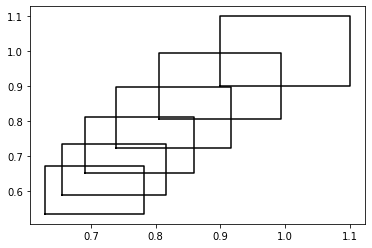

In [71]:
plot_boxes_2d(boxes)

In [72]:
for b in boxes:
    xL, xU = b[0]
    yL, yU = b[1]
    print((xU-xL)*(yU-yL))

0.03999895701348137
0.03534399760363509
0.03063167829104399
0.026558772138820682
0.02329263980652273
0.02079931290492695


In [73]:
boxes[0]

([array(0.90001421), array(1.1000116)], [array(0.90001421), array(1.1000116)])

0.9000073794293308 0.9000142073439803 1.1000115998606863
Time:  0
(0.9000073794293308, 1.0466173500342042)
([array(0.90001421), array(1.1000116)], [array(0.90001421), array(1.1000116)])
0

False


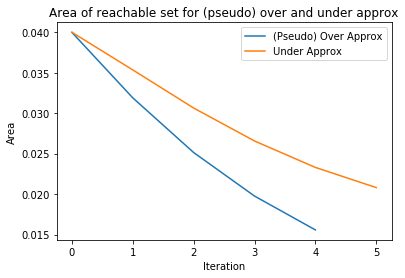

In [74]:
num_samples = 10000
print(verify_valid_boxes(boxes,[x_range,y_range],n=num_samples,forwardEuler=forwardEulerLV,constants=constants, debug=True))

In [75]:
a_x_upper, b_x_upper, c_x_upper = x_upper
a_x_lower, b_x_lower, c_x_lower = x_lower
a_y_upper, b_y_upper, c_y_upper = y_upper
a_y_lower, b_y_lower, c_y_lower = y_lower

c = np.array([[1,1,0,0]]).T

A_final = torch.tensor([[1.,0., -1.*a_x_upper, -1.*b_x_upper],
                       [-1.,0., a_x_lower, b_x_lower],
                       [0.,1., -1.*a_y_upper, -1.*b_y_upper],
                       [0.,-1., a_y_lower, b_y_lower]], requires_grad=True)
b_final = torch.tensor([[c_x_upper],[-1.*c_x_lower],[c_y_upper],[-1.*c_y_lower]], requires_grad=True)
    
z = torch.zeros((4,2))
A_freund = torch.vstack((torch.hstack((z,A_init)),A_final))
b_freund = torch.vstack((b_init,b_final))

y = freund(A_freund,b_freund,c)
y.backward()
print(b_init.grad)

tensor([[1.0036e-05],
        [2.8632e-06],
        [4.6899e-06],
        [1.5830e-06]])


In [76]:
def compute_rs(b_constraint, params):
    T = params["T"]
    a, b, c, d, l, m = params["a"], params["b"], params["c"], params["d"], params["l"], params["m"]
    dt = params["dt"]
    x0, y0 = params["x0"], params["y0"]

    A_init = torch.tensor([[1.,0.],[-1.,0.],[0.,1.],[0.,-1.]], requires_grad=False)
    b_init = torch.tensor(b_constraint, requires_grad=True)

    x_range, y_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev]

    boxes = []

    x_lower, x_upper = [1,0,0], [1,0,0]
    y_lower, y_upper = [0,1,0], [0,1,0]

    for t in range(0,T):
        xL, xU = eval_box(x_lower, x_upper, A_init, b_init)
        yL, yU = eval_box(y_lower, y_upper, A_init, b_init)
        boxes.append(([xL, xU],[yL, yU]))

        a_lower, a_upper = mul_const(x_lower, x_upper, -1*l)
        b_lower, b_upper = mul_const(y_lower, y_upper, -1*b)
        ab_lower, ab_upper = add(a_lower, a_upper, b_lower, b_upper)
        abc_lower, abc_upper = add_const(ab_lower, ab_upper, a)
        d_lower, d_upper = mul_const(x_lower, x_upper, dt)
        abcd_lower, abcd_upper = mul(abc_lower, abc_upper, d_lower, d_upper, A_init, b_init)
        abcde_lower, abcde_upper = add(abcd_lower, abcd_upper, x_lower, x_upper)

        f_lower, f_upper = mul_const(x_lower, x_upper, c)
        g_lower, g_upper = mul_const(y_lower, y_upper, -1*m)
        fg_lower, fg_upper = add(f_lower, f_upper, g_lower, g_upper)
        fgh_lower, fgh_upper = add_const(fg_lower, fg_upper, -1*d)
        i_lower, i_upper = mul_const(y_lower, y_upper, dt)
        fghi_lower, fghi_upper = mul(fgh_lower, fgh_upper, i_lower, i_upper, A_init, b_init)
        fghij_lower, fghij_upper = add(fghi_lower, fghi_upper, y_lower, y_upper)

        x_lower, x_upper = abcde_lower, abcde_upper
        y_lower, y_upper = fghij_lower, fghij_upper

    xL, xU = eval_box(x_lower, x_upper, A_init, b_init)
    yL, yU = eval_box(y_lower, y_upper, A_init, b_init)
    boxes.append(([xL, xU],[yL, yU]))

    a_x_upper, b_x_upper, c_x_upper = x_upper
    a_x_lower, b_x_lower, c_x_lower = x_lower
    a_y_upper, b_y_upper, c_y_upper = y_upper
    a_y_lower, b_y_lower, c_y_lower = y_lower

    c = np.array([[1,1,0,0]]).T

    A_final = torch.tensor([[1.,0., -1.*a_x_upper, -1.*b_x_upper],
                           [-1.,0., a_x_lower, b_x_lower],
                           [0.,1., -1.*a_y_upper, -1.*b_y_upper],
                           [0.,-1., a_y_lower, b_y_lower]], requires_grad=True)
    b_final = torch.tensor([[c_x_upper],[-1.*c_x_lower],[c_y_upper],[-1.*c_y_lower]], requires_grad=True)

    z = torch.zeros((4,2))
    A_freund = torch.vstack((torch.hstack((z,A_init)),A_final))
    b_freund = torch.vstack((b_init,b_final))

    y = freund(A_freund,b_freund,c)
    y.backward()
    
    return boxes, y.detach().numpy(), b_init.grad.numpy()

def numerical_grad(f,b,epsilon,params):
    ys_1, ys_2 = [], []
    size = b.shape[0]
    for i in range(len(b)):
        b_dev = b[:,:] + np.eye(1,size,i).T*epsilon
        _, y, _ = f(b_dev, params)
        ys_1.append(y)
        
        b_dev = b[:,:] - np.eye(1,size,i).T*epsilon
        _, y, _ = f(b_dev, params)
        ys_2.append(y)
        
#     _, y, _ = compute_rs(b_constraint, params)
    return (np.array([ys_1]).T - np.array([ys_2]).T)/(2*epsilon)

In [77]:
params = {"T":5, "a":1, "b":1, "c":1, "d":1, "l":1, "m":1, "dt":0.1, "C":np.array([[1,1,0,0]]).T,
         "x0":1, "y0":1}
bounds = [[0.5,1.5],[0.5,1.5]]

In [78]:
b_constraint = [[bounds[0][1]],[-bounds[0][0]],[bounds[1][1]],[-bounds[1][0]]]
print(numerical_grad(compute_rs,np.array(b_constraint),0.1,params))
print(numerical_grad(compute_rs,np.array(b_constraint),0.001,params))
_, _, torch_grad = compute_rs(b_constraint, params)
print(torch_grad)

[[0.64644213]
 [0.        ]
 [0.2460263 ]
 [0.        ]]
[[0.64644213]
 [0.        ]
 [0.2460263 ]
 [0.        ]]
[[-6.2564391e-06]
 [-1.9466809e-06]
 [-3.1650211e-06]
 [-1.3292547e-06]]


### Testing Numerical Gradient Calculation

In [79]:
def f(x,params):
    return None, np.square(np.linalg.norm(x,2)), None
def g(x,params):
    return None, np.sum(x), None
for eps in [0.1, 0.01, 0.001]:
    print(numerical_grad(f,np.array([[1,1,1,1,1]]).T,eps,[]))
    print(numerical_grad(g,np.array([[1,1,1,1,1]]).T,eps,[]))

[[2.]
 [2.]
 [2.]
 [2.]
 [2.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[2.]
 [2.]
 [2.]
 [2.]
 [2.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[2.]
 [2.]
 [2.]
 [2.]
 [2.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


## Refinement Code

In [80]:
class RefinedFRSTree:
    def __init__(self, bounds, params, refinement_level):
        self.bounds = copy.deepcopy(bounds)
        self.params = params.copy()
        self.refinement_level = refinement_level
        
        boxes, _, grad = self.compute_rs(self.bounds, self.params)
        self.rs = boxes
        
        self.left, self.right = None, None
        if self.refinement_level > 0:
            d = [b[1]-b[0] for b in self.bounds]
            dz = []
            for el in d:
                dz.append(el)
                dz.append(el)
            split_ind = np.argmax(np.diag(dz)@grad)//2 # split where the change is most positive as c points in the direction of the obstacle
            bounds_l, bounds_r = copy.deepcopy(self.bounds), copy.deepcopy(self.bounds)
            split_val = (self.bounds[split_ind][0] + self.bounds[split_ind][1])/2
            bounds_l[split_ind][1] = split_val
            bounds_r[split_ind][0] = split_val
            self.left = RefinedFRSTree(bounds_l, self.params, self.refinement_level-1)
            self.right = RefinedFRSTree(bounds_r, self.params, self.refinement_level-1)
            
    def compute_rs(self, bounds, params):
        T = params["T"]
        a, b, c, d, l, m = params["a"], params["b"], params["c"], params["d"], params["l"], params["m"]
        dt = params["dt"]
        x0, y0 = params["x0"], params["y0"]
        
        A_init = torch.tensor([[1.,0.],[-1.,0.],[0.,1.],[0.,-1.]], requires_grad=False)
        b_init = torch.tensor([[bounds[0][1]],[-bounds[0][0]],[bounds[1][1]],[-bounds[1][0]]], requires_grad=True)

        x_range, y_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev]
        
        boxes = []

        x_lower, x_upper = [1,0,0], [1,0,0]
        y_lower, y_upper = [0,1,0], [0,1,0]

        for t in range(0,T):
            xL, xU = eval_box(x_lower, x_upper, A_init, b_init)
            yL, yU = eval_box(y_lower, y_upper, A_init, b_init)
            boxes.append(([xL, xU],[yL, yU]))

            a_lower, a_upper = mul_const(x_lower, x_upper, -1*l)
            b_lower, b_upper = mul_const(y_lower, y_upper, -1*b)
            ab_lower, ab_upper = add(a_lower, a_upper, b_lower, b_upper)
            abc_lower, abc_upper = add_const(ab_lower, ab_upper, a)
            d_lower, d_upper = mul_const(x_lower, x_upper, dt)
            abcd_lower, abcd_upper = mul(abc_lower, abc_upper, d_lower, d_upper, A_init, b_init)
            abcde_lower, abcde_upper = add(abcd_lower, abcd_upper, x_lower, x_upper)

            f_lower, f_upper = mul_const(x_lower, x_upper, c)
            g_lower, g_upper = mul_const(y_lower, y_upper, -1*m)
            fg_lower, fg_upper = add(f_lower, f_upper, g_lower, g_upper)
            fgh_lower, fgh_upper = add_const(fg_lower, fg_upper, -1*d)
            i_lower, i_upper = mul_const(y_lower, y_upper, dt)
            fghi_lower, fghi_upper = mul(fgh_lower, fgh_upper, i_lower, i_upper, A_init, b_init)
            fghij_lower, fghij_upper = add(fghi_lower, fghi_upper, y_lower, y_upper)

            x_lower, x_upper = abcde_lower, abcde_upper
            y_lower, y_upper = fghij_lower, fghij_upper

        xL, xU = eval_box(x_lower, x_upper, A_init, b_init)
        yL, yU = eval_box(y_lower, y_upper, A_init, b_init)
        boxes.append(([xL, xU],[yL, yU]))
        
        a_x_upper, b_x_upper, c_x_upper = x_upper
        a_x_lower, b_x_lower, c_x_lower = x_lower
        a_y_upper, b_y_upper, c_y_upper = y_upper
        a_y_lower, b_y_lower, c_y_lower = y_lower

        c = np.array([[1,1,0,0]]).T

        A_final = torch.tensor([[1.,0., -1.*a_x_upper, -1.*b_x_upper],
                               [-1.,0., a_x_lower, b_x_lower],
                               [0.,1., -1.*a_y_upper, -1.*b_y_upper],
                               [0.,-1., a_y_lower, b_y_lower]], requires_grad=True)
        b_final = torch.tensor([[c_x_upper],[-1.*c_x_lower],[c_y_upper],[-1.*c_y_lower]], requires_grad=True)

        z = torch.zeros((4,2))
        A_freund = torch.vstack((torch.hstack((z,A_init)),A_final))
        b_freund = torch.vstack((b_init,b_final))

        y = freund(A_freund,b_freund,c)
        y.backward()

        return boxes, y.detach().numpy(), b_init.grad.numpy()
    
    def collect_rs(self,depth):
        ret = []
        if depth==0:
            ret.append(self.rs)
        elif depth>0:
            ret.extend(self.left.collect_rs(depth-1))
            ret.extend(self.right.collect_rs(depth-1))
        return ret
        

In [81]:
params = {"T":10, "a":1, "b":1, "c":1, "d":1, "l":1, "m":1, "dt":0.1, "C":np.array([[1,0,0,0]]).T,
         "x0":1, "y0":1}
bounds = [[5.,10.],[5.,10.]]
r = 3
root_FRS = RefinedFRSTree(bounds, params, r)

In [82]:
len(root_FRS.collect_rs(r))

8

In [83]:
def plot_boxes_refined(c,b=bounds):
    fig, ax = plt.subplots()
    ax.set_xlim([bounds[0][0]-5, bounds[0][1]+5])
    ax.set_ylim([bounds[1][0]-5, bounds[1][1]+5])
    for boxes in c:
        for i in range(len(boxes)):
            box = boxes[i]
            xL, xU = box[0]
            yL, yU = box[1]
            plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
    plt.show()

def plot_boxes_refined_initial(c,b=bounds):
    fig, ax = plt.subplots()
    ax.set_xlim([bounds[0][0]-5, bounds[0][1]+5])
    ax.set_ylim([bounds[1][0]-5, bounds[1][1]+5])
    for boxes in c:
        box = boxes[0]
        xL, xU = box[0]
        yL, yU = box[1]
        plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
#         ax.add_patch(Rectangle((xL, yL), xU-xL, yU-yL))
    plt.show()

def plot_boxes_refined_final(c,b=bounds):
    fig, ax = plt.subplots()
    ax.set_xlim([bounds[0][0]-5, bounds[0][1]+5])
    ax.set_ylim([bounds[1][0]-5, bounds[1][1]+5])
    for boxes in c:
        box = boxes[-1]
        xL, xU = box[0]
        yL, yU = box[1]
        plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
#         ax.add_patch(Rectangle((xL, yL), xU-xL, yU-yL))
    plt.show()

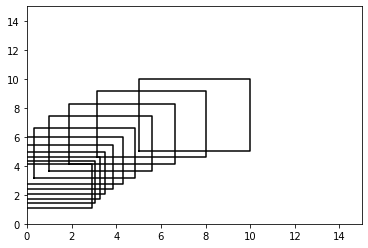

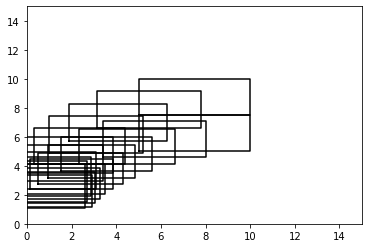

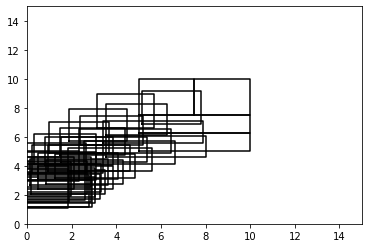

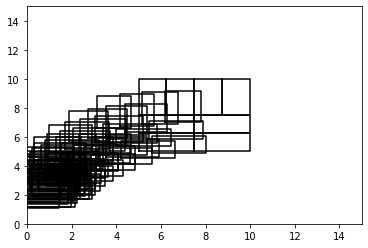

In [84]:
for i in range(r+1):
    plot_boxes_refined(root_FRS.collect_rs(i))

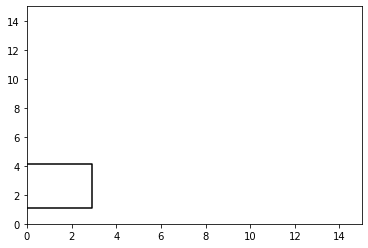

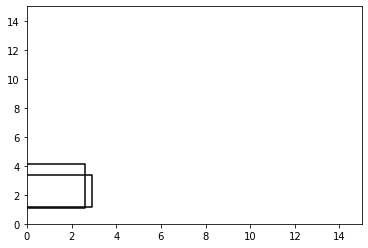

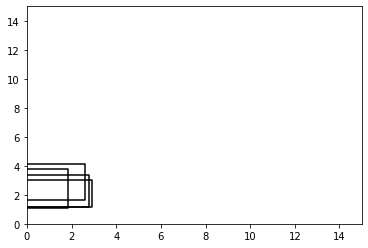

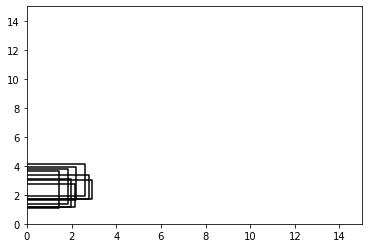

In [85]:
for i in range(4):
    plot_boxes_refined_final(root_FRS.collect_rs(i))

In [86]:
# [b[-1] for b in root_FRS.collect_rs(0)]

In [87]:
# [b[-1] for b in root_FRS.collect_rs(1)]

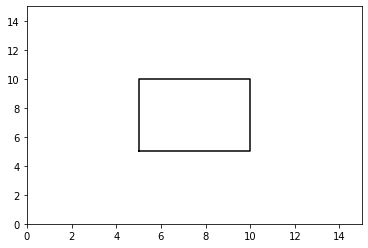

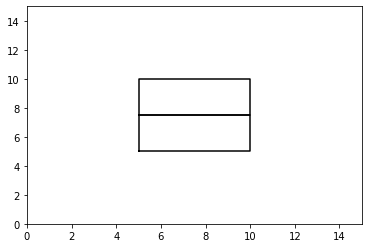

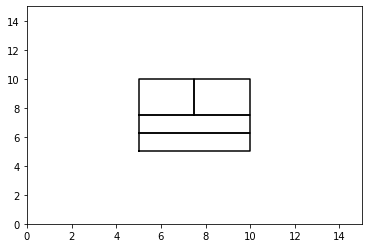

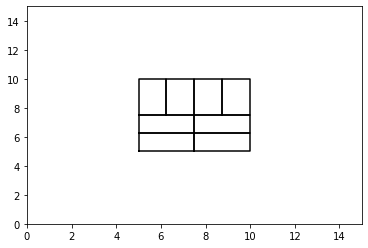

In [88]:
for i in range(4):
    plot_boxes_refined_initial(root_FRS.collect_rs(i))

## Old Approach

In [ ]:
T = 10
a, b, c, d, l, m = 1, 1, 1, 1, 1, 1
dt = 0.1
A_init = torch.tensor([[1.,0.],[-1.,0.],[0.,1.],[0.,-1.]], requires_grad=False)
b_init = torch.tensor([[1+0.01],[-(1-0.01)],[1+0.01],[-(1-0.01)]], requires_grad=True)

constraints = {}
boxes = []

a_x_lower, b_x_lower, c_x_lower = 1, 0, 0
a_x_upper, b_x_upper, c_x_upper = 1, 0, 0
a_y_lower, b_y_lower, c_y_lower = 0, 1, 0
a_y_upper, b_y_upper, c_y_upper = 0, 1, 0

A_0 = torch.tensor([[1.,0., -1.*a_x_upper, -1.*b_x_upper],
                       [-1.,0., a_x_lower, b_x_lower],
                       [0.,1., -1.*a_y_upper, -1.*b_y_upper],
                       [0.,-1., a_y_lower, b_y_lower]], requires_grad=True)
b_0 = torch.tensor([[c_x_upper],[-1.*c_x_lower],[c_y_upper],[-1.*c_y_lower]], requires_grad=True)

constraints[0] = (A_0,b_0)

In [65]:
for t in range(1,T):
    
    # Construct constraints to calculate bounds on previous variables x_{t-1}, y_{t-1}
    A_prev, b_prev = constraints[t-1]
    z = torch.zeros((4,2))
    A_freund = torch.vstack((torch.hstack((z,A_init)),A_prev))
    b_freund = torch.vstack((b_init,b_prev))
    
    c_x = np.array([[1,0,0,0]]).T
    c_y = np.array([[0,1,0,0]]).T
    x_prev_lower, x_prev_upper = -1.*freund(A_freund,b_freund,-1.*c_x), freund(A_freund,b_freund,c_x) # minimize and maximize x_i
    y_prev_lower, y_prev_upper = -1.*freund(A_freund,b_freund,-1.*c_y), freund(A_freund,b_freund,c_y) # minimize and maximize y_i
    
    boxes.append(([x_prev_lower, x_prev_upper],[y_prev_lower, y_prev_upper]))
    
    # Calculate coefficients of x_t/y_t \leq a x_{t-1} + ...
#     a_x_t_lower, b_x_t_lower, c_x_t_lower
    
    a_x_t_lower, b_x_t_lower, c_x_t_lower = a*dt + 1 - y_prev_lower*b*dt - l*dt*2*x_prev_upper, -b*dt*x_prev_upper, b*dt*x_prev_upper*y_prev_lower - l*dt*x_prev_upper*x_prev_lower
    a_x_t_upper, b_x_t_upper, c_x_t_upper = a*dt + 1 - y_prev_upper*b*dt - l*dt*2*x_prev_upper, -b*dt*x_prev_upper, b*dt*x_prev_upper*y_prev_upper + l*dt*x_prev_upper*x_prev_upper
    a_y_t_lower, b_y_t_lower, c_y_t_lower = c*dt*y_prev_upper, c*dt*x_prev_upper + 1 - d*dt - dt*m*y_prev_upper - dt*m*y_prev_lower, dt*m*y_prev_upper*y_prev_lower - c*dt*x_prev_upper*y_prev_upper
    a_y_t_upper, b_y_t_upper, c_y_t_upper = c*dt*y_prev_lower, c*dt*x_prev_upper + 1 - d*dt - 2*dt*m*y_prev_upper, dt*m*y_prev_upper*y_prev_upper - c*dt*x_prev_upper*y_prev_lower
    
    a_x_lower_prev, b_x_lower_prev, c_x_lower_prev = A_prev[1,2], A_prev[1,3], -1.*b_prev[1,0]
    a_x_upper_prev, b_x_upper_prev, c_x_upper_prev = -1.*A_prev[0,2], -1.*A_prev[0,3], b_prev[0,0]
    a_y_lower_prev, b_y_lower_prev, c_y_lower_prev = A_prev[3,2], A_prev[3,3], -1.*b_prev[3,0]
    a_y_upper_prev, b_y_upper_prev, c_y_upper_prev = -1.*A_prev[2,2], -1.*A_prev[2,3], b_prev[2,0]
    
    # Calculate coefficients wrt x_0/y_0
    a_x_lower, b_x_lower, c_x_lower = [a_x_t_lower*(a_x_lower_prev if a_x_t_lower > 0 else a_x_upper_prev) + b_x_t_lower*(a_y_lower_prev if b_x_t_lower > 0 else a_y_upper_prev),
                                        a_x_t_lower*(b_x_lower_prev if a_x_t_lower > 0 else b_x_upper_prev) + b_x_t_lower*(b_y_lower_prev if b_x_t_lower > 0 else b_y_upper_prev),
                                        c_x_t_lower + a_x_t_lower*(c_x_lower_prev if a_x_t_lower > 0 else c_x_upper_prev) + b_x_t_lower*(c_y_lower_prev if b_x_t_lower > 0 else c_y_upper_prev)]
            
    a_x_upper, b_x_upper, c_x_upper = [a_x_t_upper*(a_x_lower_prev if a_x_t_upper <= 0 else a_x_upper_prev) + b_x_t_upper*(a_y_lower_prev if b_x_t_upper <= 0 else a_y_upper_prev),
                                        a_x_t_upper*(b_x_lower_prev if a_x_t_upper <= 0 else b_x_upper_prev) + b_x_t_upper*(b_y_lower_prev if b_x_t_upper <= 0 else b_y_upper_prev),
                                        c_x_t_upper + a_x_t_upper*(c_x_lower_prev if a_x_t_upper <= 0 else c_x_upper_prev) + b_x_t_upper*(c_y_lower_prev if b_x_t_upper <= 0 else c_y_upper_prev)]
            
    a_y_lower, b_y_lower, c_y_lower = [a_y_t_lower*(a_x_lower_prev if a_y_t_lower > 0 else a_x_upper_prev) + b_y_t_lower*(a_y_lower_prev if b_y_t_lower > 0 else a_y_upper_prev),
                                        a_y_t_lower*(b_x_lower_prev if a_y_t_lower > 0 else b_x_upper_prev) + b_y_t_lower*(b_y_lower_prev if b_y_t_lower > 0 else b_y_upper_prev),
                                        c_y_t_lower + a_y_t_lower*(c_x_lower_prev if a_y_t_lower > 0 else c_x_upper_prev) + b_y_t_lower*(c_y_lower_prev if b_y_t_lower > 0 else c_y_upper_prev)]
            
    a_y_upper, b_y_upper, c_y_upper = [a_y_t_upper*(a_x_lower_prev if a_y_t_upper <= 0 else a_x_upper_prev) + b_y_t_upper*(a_y_lower_prev if b_y_t_upper <= 0 else a_y_upper_prev),
                                        a_y_t_upper*(b_x_lower_prev if a_y_t_upper <= 0 else b_x_upper_prev) + b_y_t_upper*(b_y_lower_prev if b_y_t_upper <= 0 else b_y_upper_prev),
                                        c_y_t_upper + a_y_t_upper*(c_x_lower_prev if a_y_t_upper <= 0 else c_x_upper_prev) + b_y_t_upper*(c_y_lower_prev if b_y_t_upper <= 0 else c_y_upper_prev)]
    
    A_i = torch.tensor([[1.,0., -1.*a_x_upper, -1.*b_x_upper],
                       [-1.,0., a_x_lower, b_x_lower],
                       [0.,1., -1.*a_y_upper, -1.*b_y_upper],
                       [0.,-1., a_y_lower, b_y_lower]], requires_grad=True)
    b_i = torch.tensor([[c_x_upper],[-1.*c_x_lower],[c_y_upper],[-1.*c_y_lower]], requires_grad=True)
    
    constraints[t] = (A_i,b_i)

In [66]:
def plot_boxes_2d_torch(boxes):
    plt.figure()
    for i in range(len(boxes)):
        box = boxes[i]
        xL, xU = box[0]
        yL, yU = box[1]
        xL, xU = xL.detach().numpy(), xU.detach().numpy()
        yL, yU = yL.detach().numpy(), yU.detach().numpy()
        plt.plot([xL,xL,xU,xU,xL],[yL,yU,yU,yL,yL],'k')
    plt.show()

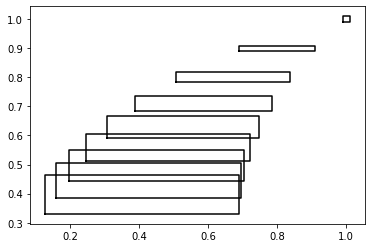

In [67]:
plot_boxes_2d_torch(boxes)

In [68]:
boxes

[([tensor(0.9900, dtype=torch.float64, grad_fn=<MulBackward0>),
   tensor(1.0100, dtype=torch.float64, grad_fn=<FreundBackward>)],
  [tensor(0.9900, dtype=torch.float64, grad_fn=<MulBackward0>),
   tensor(1.0100, dtype=torch.float64, grad_fn=<FreundBackward>)]),
 ([tensor(0.6890, dtype=torch.float64, grad_fn=<MulBackward0>),
   tensor(0.9090, dtype=torch.float64, grad_fn=<FreundBackward>)],
  [tensor(0.8910, dtype=torch.float64, grad_fn=<MulBackward0>),
   tensor(0.9090, dtype=torch.float64, grad_fn=<FreundBackward>)]),
 ([tensor(0.5072, dtype=torch.float64, grad_fn=<MulBackward0>),
   tensor(0.8361, dtype=torch.float64, grad_fn=<FreundBackward>)],
  [tensor(0.7837, dtype=torch.float64, grad_fn=<MulBackward0>),
   tensor(0.8179, dtype=torch.float64, grad_fn=<FreundBackward>)]),
 ([tensor(0.3883, dtype=torch.float64, grad_fn=<MulBackward0>),
   tensor(0.7840, dtype=torch.float64, grad_fn=<FreundBackward>)],
  [tensor(0.6828, dtype=torch.float64, grad_fn=<MulBackward0>),
   tensor(0.7374

In [69]:
A_final, b_final = constraints[T-1]
z = torch.zeros((4,2))
A_freund = torch.vstack((torch.hstack((z,A_init)),A_final))
b_freund = torch.vstack((b_init,b_final))
c = np.array([[1,1,0,0]]).T
y = freund(A_freund,b_freund,c)
y.backward()
print(b_init.grad)

tensor([[3.1937e-06],
        [1.0291e-06],
        [4.4097e-07],
        [7.2741e-07]])


In [70]:
np.argmax(np.abs(b_init.grad.numpy()))

0